In [1]:
from astropy.table import Table, unique
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from RC_plotting_functions import plot_rot_curve
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from rotation_fitfunctions import find_incl
%matplotlib inline

In [2]:
NFW = Table.read('/scratch/lstroud3/RotationCurves/Images/NFW/fulltable.fits')
iso = Table.read('/scratch/lstroud3/RotationCurves/Images/Isothermal/fulltable.fits')
bur = Table.read('/scratch/lstroud3/RotationCurves/Images/Burkert/fulltable.fits')

In [3]:
NFWchi2 = NFW['chi2']
isochi2 = iso['chi2']
burchi2 = bur['chi2']

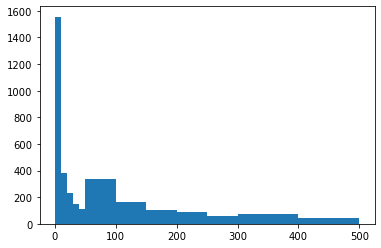

In [4]:
nfwc2=plt.hist(NFWchi2, bins=(0,10,20,30,40,50,100,150,200,250,300,400,500))[0] #3581 tot fits

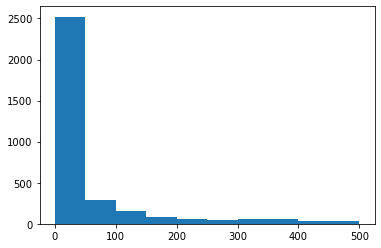

In [5]:
isoc2 = plt.hist(isochi2, bins=(0,50,100,150,200,250,300,400,500))[0] #3479

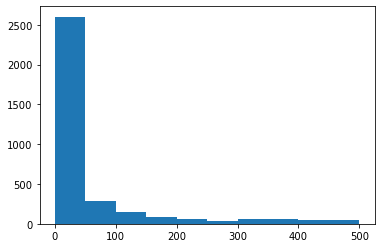

In [6]:
burc2 = plt.hist(burchi2, bins=(0,50,100,150,200,250,300,400,500))[0] #3568

In [7]:
print(nfwc2, burc2, isoc2)

[1556.  382.  228.  146.  109.  336.  164.  101.   87.   57.   73.   46.] [2601.  289.  150.   87.   61.   40.   59.   50.] [2521.  286.  150.   88.   54.   50.   59.   34.]


In [8]:
iso_index = {}
for i in range(len(iso)):
    gal = iso['plateifu'][i]
    iso_index[gal] = i

In [9]:
iso_list = []
for gal_ID in iso['plateifu']:
    ind = iso_index[gal_ID]
    if (iso['fit flag'][ind] == -6) or (iso['fit flag'][ind] == -5):
        iso_list.append(gal_ID)
    


In [10]:
NFW_index = {}
for i in range(len(NFW)):
    gal = NFW['plateifu'][i]
    NFW_index[gal] = i
NFW_list = []
for gal_ID in NFW['plateifu']:
    ind = NFW_index[gal_ID]
    if (NFW['fit flag'][ind] == -6) or (NFW['fit flag'][ind] == -5):
        NFW_list.append(gal_ID)
    


In [11]:
bur_index = {}
for i in range(len(bur)):
    gal = bur['plateifu'][i]
    bur_index[gal] = i
bur_list = []
for gal_ID in bur['plateifu']:
    ind = bur_index[gal_ID]
    if (bur['fit flag'][ind] == -6) or (bur['fit flag'][ind] == -5):
        bur_list.append(gal_ID)
    


In [12]:
isochi2= []
burchi2 = []
nfwchi2 = []
for gal_ID in NFW['plateifu']:
    nind = NFW_index[gal_ID]
    iind = iso_index[gal_ID]
    bind = bur_index[gal_ID]
    if NFW['chi2'][nind] > 50:
        nfwchi2.append(gal_ID)
    if bur['chi2'][bind] > 50:
        burchi2.append(gal_ID)
    if iso['chi2'][iind] > 50:
        isochi2.append(gal_ID)

In [13]:
is_good = {}
for gal_ID in iso['plateifu']:
    code = 0
    if gal_ID in isochi2:
        code += 100
    elif gal_ID in iso_list:
        code += 200
    if gal_ID in nfwchi2:
        code += 10
    elif gal_ID in NFW_list:
        code += 20
    if gal_ID in burchi2:
        code += 1
    elif gal_ID in bur_list:
        code += 2
    is_good[gal_ID] = code
    
    

In [14]:
MANGA_FOLDER = '/scratch/kdougla7/data/SDSS/dr17/manga/spectro/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v3_1_1/' + 'drpall-v3_1_1.fits'
DRP_table = Table.read( DRP_FILENAME, format='fits')
DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]
    DRP_index[galaxy_ID] = i


In [15]:
full_table = Table(DRP_table)

In [16]:
full_table['Isothermal chi2'] = np.nan
full_table['NFW chi2'] = np.nan
full_table['Burkert chi2'] = np.nan
full_table['fitting code'] = np.nan

In [17]:
for gal_ID in full_table['plateifu']:
    indi = iso_index[gal_ID]
    indb = bur_index[gal_ID]
    indn = NFW_index[gal_ID]
    index = DRP_index[gal_ID]
    full_table['Isothermal chi2'][index] = iso['chi2'][indi]
    full_table['NFW chi2'][index] = NFW['chi2'][indn]
    full_table['Burkert chi2'][index] = bur['chi2'][indb]
    full_table['fitting code'][index] = is_good[gal_ID]

/software/anaconda3/2021.11/lib/python3.9/site-packages/astropy/table/column.py:1121: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [18]:
print(full_table['plateifu','Isothermal chi2', 'NFW chi2', 'Burkert chi2', 'fitting code'])

  plateifu    Isothermal chi2   ...     Burkert chi2    fitting code
----------- ------------------- ... ------------------- ------------
10001-12701  19.767796961088965 ...  20.703030275554678         10.0
10001-12702 0.07933463869169648 ... 0.07734832160793538          0.0
10001-12703                 nan ...                 nan        222.0
10001-12704    69.9094356645712 ...   72.57880734087789        111.0
10001-12705   31.35986067881697 ...  30.993668820972488          0.0
 10001-1901                 nan ...                 nan        222.0
 10001-1902                 nan ...                 nan          0.0
 10001-3701                 nan ...                 nan          0.0
 10001-3702                 nan ...                 nan          0.0
 10001-3703                 nan ...                 nan        202.0
        ...                 ... ...                 ...          ...
  9894-1902                 nan ...                 nan          0.0
  9894-3701                 nan ..

In [20]:
full_failed_object_table = full_table[full_table['fitting code']>0]
full_failed_object_table.write('/scratch/lstroud3/RotationCurves/failed_objects_table.fits')

In [21]:
t = full_failed_object_table['plateifu','Isothermal chi2', 'NFW chi2', 'Burkert chi2', 'fitting code']

In [22]:
t.show_in_notebook()

idx,plateifu,Isothermal chi2,NFW chi2,Burkert chi2,fitting code
0,10001-12701,19.767796961088965,51.44618615361385,20.703030275554678,10.0
1,10001-12703,nan,nan,nan,222.0
2,10001-12704,69.9094356645712,92.13130723533656,72.57880734087789,111.0
3,10001-1901,nan,nan,nan,222.0
4,10001-3703,nan,20.41809716700918,nan,202.0
5,10001-6102,nan,450.5157428520964,346.15632731331874,211.0
6,10001-6104,nan,0.08009499098223621,0.05229184251391343,200.0
7,10213-12705,247.5217905546299,256.81836984695246,247.40208245409084,111.0
8,10213-1902,188.0469312907436,191.52580864572667,188.4475188919184,111.0
9,10213-6103,nan,nan,nan,222.0


In [25]:
failed = t[t['fitting code']==222]
failed.show_in_notebook()

idx,plateifu,Isothermal chi2,NFW chi2,Burkert chi2,fitting code
0,10001-12703,nan,nan,nan,222.0
1,10001-1901,nan,nan,nan,222.0
2,10213-6103,nan,nan,nan,222.0
3,10215-1902,nan,nan,nan,222.0
4,10215-3703,nan,nan,nan,222.0
5,10217-3703,nan,nan,nan,222.0
6,10218-3703,nan,nan,nan,222.0
7,10218-3704,nan,nan,nan,222.0
8,10219-12703,nan,nan,nan,222.0
9,10219-12704,nan,nan,nan,222.0


In [33]:
x = t['fitting code']

    

In [36]:
a = np.unique(x,return_counts=True)

In [37]:
print(a)

(<Column name='fitting code' dtype='float64' length=25>
  1.0
  2.0
 10.0
 11.0
 12.0
 20.0
 22.0
100.0
101.0
102.0
110.0
111.0
112.0
120.0
121.0
122.0
200.0
201.0
202.0
210.0
211.0
212.0
220.0
221.0
222.0, array([  1,  75, 129,   5,   8, 117,  62,  13,   2,   1,  16, 797,  50,
         3,  42,  34, 121,   1,  83,  10,  75,  70,  68,  44, 690]))


In [ ]:
"""
1:1 1 bad, 2 good
2:75 1 fail, 2 good
10:129 1 bad, 2 good
11:5 2 bad, 1 good
12:8 1 fail, 1 bad, 1 good
20:117 1 fail, 2 good
22:62 2 fail, 1 good
100:13 1 bad, 2 good
101:2 2 bad, 1 good
102:1 1 fail, 1 bad, 1 good
110:16 2 bad, 1 good
111:797 3 bad
112:50 1 fail, 2 bad
120:3 1 fail, 1 bad, 1 good
121:42 1 fail, 2 bad
122:34 2 fail, 1 bad
200:121 1 fail, 2 bad
201:1 1 fail, 1 bad, 1 good
202:83 2 fail, 1 good
210:10 1 fail, 1 bad, 1 good
211:75 1 fail, 2 bad fit
212:70 2 fail, 1 bad fit
220:68 2 fail, 1 good fit
221:44  2 fail, 1 bad fit
222:690 all three fits completely failed

All fail: 690
2 Fail 1 Bad: 148
2 Fail 1 good: 213
1 Fail 2 Bad: 288
1 Fail 1 Bad 1 Good: 15 
1 Fail 2 Good: 193
All bad: 797
2 bad 1 good:23
1 bad 2 good:143


"""

